In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
from matplotlib import animation
from IPython.display import HTML

In [5]:
# Set the font family and the size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [7]:
from Traffic import rho_red_light, flux

In [8]:
help(rho_red_light)

Help on function rho_red_light in module Traffic:

rho_red_light(x, rho_max)
    Computes the "red light" initial condition with shock.
    Parameters
    ----------
    x : numpy.ndarray
        Locations on the road as a 1D array of floats.
    rho_max : float
        The maximum traffic density allowed.
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road as a 1D array of floats.



In [9]:
# Set parameters.
nx = 100 # number of cells along the road
L = 4.0 # length of the road
dx = L / nx # cell width
nt = 30 # number of time-steps to compute
rho_max = 10.0 # maximum traffic density allowed
u_max = 1.0 # speed limit

# Get the grid-cell centers.
# x_i is now the center of the i-th cell.
x = np.linspace(0.0 + 0.5 * dx, L - 0.5 * dx, num=nx)

# Compute the initial traffic density.
rho0 = rho_red_light(x, rho_max)

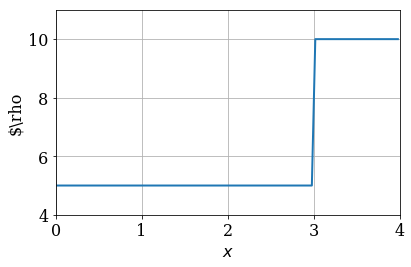

In [23]:
# plot the initial car density on the road.
fig = plt.figure(figsize=(6.0, 4.0))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho')
plt.grid()
line = plt.plot(x, rho0, color='C0', linestyle='-', linewidth=2)[0]
plt.xlim(0.0, L)
plt.ylim(4.0, 11.0)
plt.tight_layout();

In [12]:
def godunov(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes and returns the history of the traffic density
    on the road using a Godunov scheme
    with a Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : tuple or list
        The value of the density at the first and last locations
        as a tuple or list of two floats.
    args : list
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
        as a list of 1D arrays of floats.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        rhoL = rho[:-1] # i-th value at index i-1/2
        rhoR = rho[1:] # i+1-th value at index i-1/2
        # Compute the flux at the cell boundaries.
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) - 
                   dx / dt * (rhoR - rhoL))
        # Advance in time.
        rho[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        # Apply boundary conditions.
        rho[0], rho[-1] = bc_values
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [13]:
# Set time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time steps.
rho_hist = godunov(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                   u_max, rho_max)

In [24]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [25]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())

In [26]:
# MUSCL scheme.



In [27]:
def minmod(e, dx):
    """
    Computes the minmod approximation of the slope.
    
    Parameters
    ----------
    e : list or numpy.ndarray
        The input values as a 1D array of floats.
    dx : float
        The grid-cell width.
    
    Returns
    -------
    sigma : numpy.ndarray
        The minmod-approximated slope
        as a 1D array of floats.
    """
    sigma = np.zeros_like(e)
    for i in range(1, len(e) - 1):
        de_minus = (e[i] - e[i - 1]) / dx
        de_plus = (e[i+1] - e[i]) / dx
        if de_minus > 0 and de_plus > 0:
            sigma[i] = min(de_minus, de_plus)
        elif de_minus < 0 and de_plus < 0:
            sigma[i] = max(de_minus, de_plus)
        else:
            sigma[i] = 0.0
    return sigma

In [28]:
def muscl(who0, nt, dt, dx, bc_values, *args):
    """
    Computes and returns the history of the traffic density
    on the road using a MUSCL scheme with a minmod slope limiting
    and a Lax-Friedrichs flux.
    The function uses a second-order Runge-Kutta method
    to integrate in time.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : tuple or list
        The value of the density at the first and last locations
        as a tuple or list of two floats.
    args : list
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road
        as a list of 1D array of floats.
    """
    def compute_flux(rho):
        # Compute the minmod slope.
        sigma = minmod(rho, dx)
        # Reconstruct values at cell boundaries.
        rhoL = (rho + sigma * dx / 2.0)[:-1]
        rhoR = (rho - sigma * dx / 2.0)[1:]
        # Compute the flux.
        F = 0.5 * (flux(rhoL, *args) + flux(rhoR, *args) - 
                   dx / dt * (rhoR - rhoL))
        return F
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        # Compute the flux at cell boundaries.
        F = compute_flux(rho)
        # Perform 1st step of RK2.
        rho_star[1:-1] = rho[1:-1] - dt / dx * (F[1:] - F[:-1])
        # Apply boundary conditions.
        rho_star[0], rho_star[-1] = bc_values
        # Compute the flux at cell boundaries.
        F = compute_flux(rho_star)
        # Perform 2nd step of RK2.
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] - 
                           dt / dx * (F[1:] - F[:-1]))
        # Apply boundary conditions.
        rho[0], rho[-1] = bc_values
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [30]:
# Set time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max # time-step size

# Compute the traffic density at all time-steps.
rho_hist = muscl(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                 u_max, rho_max)

In [31]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot, 
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

# Display the video.
HTML(anim.to_html5_video())